<a href="https://colab.research.google.com/github/andreschlaepfer/EEL891---IntroML/blob/main/introml_trabalho1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro ML - Trabalho 1 
## Andre Aranha Schlaepfer

### O Objetivo desse trabalho é construir um classificador para apoio à decisão de aprovação de crédito.
### Para isso, a partir de um conjunto de 20.000 entradas de dados, devemos classificar novos clientes como
### inadimplentes ou não-inadimplentes.

***Importação das dependências utilizadas e dos conjuntos de dados***

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

*Instanciando os conjuntos de dados em df_train e df_test*

In [75]:
df_train = pd.read_csv('/content/conjunto_de_treinamento.csv')
df_test = pd.read_csv('/content/conjunto_de_teste.csv')


In [76]:
# conjunto de respostas para comparação da previsão

y_test = pd.read_csv('/content/exemplo_arquivo_respostas.csv')

In [77]:
# Visualização do conjunto de respostas

y_test

,id_solicitante,inadimplente
0,20001,0
1,20002,1
2,20003,0
3,20004,1
4,20005,0
...,...,...
4995,24996,1
4996,24997,0
4997,24998,1
4998,24999,0


# Uma breve observada no conjunto

### Aqui começamos o pré-processamento dos dados.
### A princípio vamos apenas observá-los

In [78]:
df_train

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,tipo_residencia,meses_na_residencia,possui_telefone_celular,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,1,CE,CE,Y,107,1.0,12.0,N,0,480.0,0.0,0,0,0,0,0,1,1,0.0,1,N,,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,1,SE,SE,Y,91,1.0,5.0,N,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,1,BA,BA,Y,90,5.0,1.0,N,1,600.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,1,RS,RS,Y,54,1.0,1.0,N,1,460.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,RS,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,1,BA,BA,Y,86,0.0,1.0,N,1,687.0,600.0,0,0,0,0,0,0,0,0.0,1,Y,BA,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,1,10,presencial,1,M,27,2,0,0,1,MG,MG,Y,29,2.0,0.0,N,1,423.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,1.0,0.0,0.0,308.0,308.0,0
19996,19997,1,20,presencial,1,F,26,2,1,0,1,CE,CE,Y,107,1.0,3.0,N,0,350.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,2.0,0.0,0.0,639.0,639.0,0
19997,19998,1,10,internet,1,F,63,2,0,0,1,BA,BA,Y,86,5.0,25.0,N,1,321.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,9.0,1.0,NaN,NaN,486.0,486.0,0
19998,19999,1,5,internet,1,F,84,1,0,0,1,PB,RN,N,,1.0,30.0,N,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,NaN,NaN,590.0,590.0,0


### Já é possível observar que o conjunto possui alguns dados categóricos, booleanos e que nem todos os campos estão preenchidos.
### Isso será resolvido mais tarde.

In [79]:
df_train.columns

Index(['id_solicitante', 'produto_solicitado', 'dia_vencimento',
       'forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'idade',
       'estado_civil', 'qtde_dependentes', 'grau_instrucao', 'nacionalidade',
       'estado_onde_nasceu', 'estado_onde_reside',
       'possui_telefone_residencial', 'codigo_area_telefone_residencial',
       'tipo_residencia', 'meses_na_residencia', 'possui_telefone_celular',
       'possui_email', 'renda_mensal_regular', 'renda_extra',
       'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'estado_onde_trabalha',
       'possui_telefone_trabalho', 'codigo_area_telefone_trabalho',
       'meses_no_trabalho', 'profissao', 'ocupacao', 'profissao_companheiro',
       'grau_instrucao_companheiro', 'local_onde_reside',
       '

### É possível observar que há muitas variáveis no conjunto.
### Para termos uma primeira visualização dos dados, escolhi observar como se comportavam as variáveis
### "Renda Mensal" vs "Grau de Instrução"

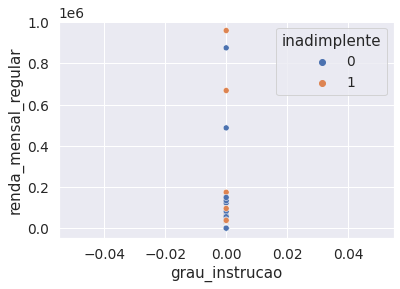

In [80]:
sns.scatterplot(data=df_train, x="grau_instrucao", y="renda_mensal_regular", hue="inadimplente")

### Nota-se que há algo de errado com a coluna "grau_instrução". 

In [81]:
df_train["grau_instrucao"].describe()

count    20000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: grau_instrucao, dtype: float64

### Percebe-se que a coluna "grau_instrucao" apresenta apenas o valor 0. Logo, não contribui para a nossa análise e deve ser droppada.

### Matriz Correlação

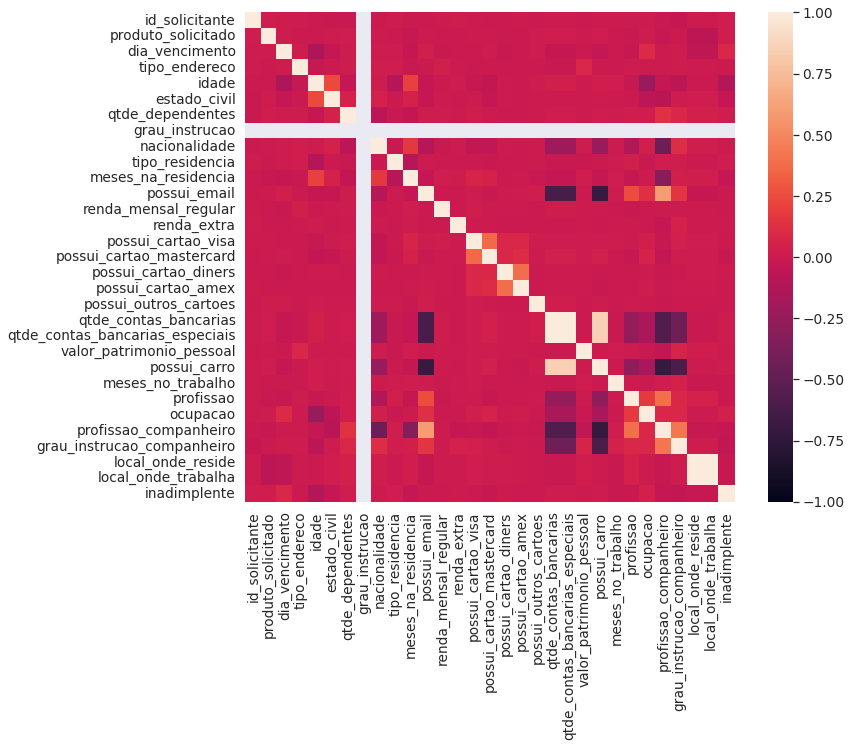

In [82]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax= 1, vmin = -1, square=True);

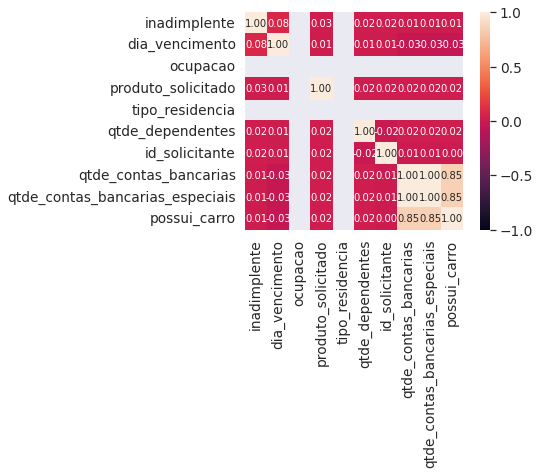

In [83]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'inadimplente')['inadimplente'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, vmax= 1, vmin = -1, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Não faz sentido analisar esse heatmap, uma vez que as variáveis categóricas devem ser tratadas antes

# Limpeza e tratamento de dados

# **Dados faltantes**

### Aqui vamos tratar os dados faltantes, que já tinham sido notados


In [84]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
dados_faltantes = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
dados_faltantes.head(20)

,Total,Percent
grau_instrucao_companheiro,12860,0.64300
profissao_companheiro,11514,0.57570
profissao,3097,0.15485
ocupacao,2978,0.14890
meses_na_residencia,1450,0.07250
tipo_residencia,536,0.02680
inadimplente,0,0.00000
grau_instrucao,0,0.00000
codigo_area_telefone_residencial,0,0.00000
possui_telefone_residencial,0,0.00000


### Escolhi eliminar as colunas que tinham mais de 50% de dados faltantes e também aquelas que tinham apenas 1 valor

In [85]:
df_train = df_train.drop((dados_faltantes[dados_faltantes['Percent'] > 0.5]).index,1)

#droppando colunas que possuem apenas 1 valor
df_train.drop('grau_instrucao',
  axis='columns', inplace=True)
df_train.drop('possui_telefone_celular',
  axis='columns', inplace=True)

In [86]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
dados_faltantes = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
dados_faltantes.head(20)

,Total,Percent
profissao,3097,0.15485
ocupacao,2978,0.14890
meses_na_residencia,1450,0.07250
tipo_residencia,536,0.02680
inadimplente,0,0.00000
qtde_dependentes,0,0.00000
codigo_area_telefone_residencial,0,0.00000
possui_telefone_residencial,0,0.00000
estado_onde_reside,0,0.00000
estado_onde_nasceu,0,0.00000


In [87]:
df_train

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,nacionalidade,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,tipo_residencia,meses_na_residencia,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,1,CE,CE,Y,107,1.0,12.0,0,480.0,0.0,0,0,0,0,0,1,1,0.0,1,N,,N,,0,9.0,1.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,1,SE,SE,Y,91,1.0,5.0,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,2.0,5.0,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,1,BA,BA,Y,90,5.0,1.0,1,600.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,1,RS,RS,Y,54,1.0,1.0,1,460.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,RS,Y,54,0,9.0,2.0,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,1,BA,BA,Y,86,0.0,1.0,1,687.0,600.0,0,0,0,0,0,0,0,0.0,1,Y,BA,N,,0,9.0,5.0,440.0,440.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,1,10,presencial,1,M,27,2,0,1,MG,MG,Y,29,2.0,0.0,1,423.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,1.0,308.0,308.0,0
19996,19997,1,20,presencial,1,F,26,2,1,1,CE,CE,Y,107,1.0,3.0,0,350.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,2.0,639.0,639.0,0
19997,19998,1,10,internet,1,F,63,2,0,1,BA,BA,Y,86,5.0,25.0,1,321.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,9.0,1.0,486.0,486.0,0
19998,19999,1,5,internet,1,F,84,1,0,1,PB,RN,N,,1.0,30.0,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,590.0,590.0,0


# Lidando com as variáveis categóricas

# Identificando

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_solicitante                    20000 non-null  int64  
 1   produto_solicitado                20000 non-null  int64  
 2   dia_vencimento                    20000 non-null  int64  
 3   forma_envio_solicitacao           20000 non-null  object 
 4   tipo_endereco                     20000 non-null  int64  
 5   sexo                              20000 non-null  object 
 6   idade                             20000 non-null  int64  
 7   estado_civil                      20000 non-null  int64  
 8   qtde_dependentes                  20000 non-null  int64  
 9   nacionalidade                     20000 non-null  int64  
 10  estado_onde_nasceu                20000 non-null  object 
 11  estado_onde_reside                20000 non-null  object 
 12  poss

In [89]:
df_train_cat = df_train.select_dtypes(include=['object']).copy()
cat_variables = [ i for i in df_train.columns if df_train[i].dtype == 'object']


#### Chamamos de "cat_variables" a lista com todas as colunas de dados categóricos do conjunto
#### Chamamos de "df_train_cat" o dataframe que contem apenas as variáveis categóricas do conjunto inicial

In [90]:
df_train_cat.T.head(11)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,19970,19971,19972,19973,19974,19975,19976,19977,19978,19979,19980,19981,19982,19983,19984,19985,19986,19987,19988,19989,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
forma_envio_solicitacao,presencial,internet,internet,internet,internet,presencial,presencial,internet,internet,presencial,presencial,internet,presencial,internet,internet,presencial,internet,presencial,internet,internet,presencial,internet,internet,presencial,internet,internet,presencial,internet,internet,internet,presencial,correio,presencial,internet,internet,internet,internet,presencial,internet,internet,...,internet,presencial,internet,internet,presencial,internet,presencial,presencial,internet,internet,presencial,internet,internet,internet,internet,internet,internet,internet,internet,internet,internet,presencial,internet,presencial,internet,internet,presencial,internet,internet,presencial,presencial,presencial,internet,internet,presencial,presencial,presencial,internet,internet,presencial
sexo,M,F,F,M,F,M,F,F,F,M,M,M,F,M,M,F,M,F,F,M,F,F,F,F,F,M,F,F,M,F,M,F,M,M,F,F,M,F,F,F,...,M,F,F,F,M,F,F,M,F,F,F,F,F,F,F,F,F,M,F,F,F,F,F,M,F,M,F,M,F,M,F,M,M,F,M,M,F,F,F,F
estado_onde_nasceu,CE,SE,BA,RS,BA,CE,SP,ES,GO,RS,BA,CE,SP,RS,CE,PR,AC,SP,RS,PE,,CE,SP,SP,PE,BA,AC,SP,BA,PE,MA,RS,BA,MG,CE,PE,CE,MT,PE,BA,...,TO,BA,PE,SP,,BA,RN,PA,ES,GO,RN,PE,RS,BA,SP,AM,PB,CE,AM,RN,RN,CE,MT,BA,PR,PI,AL,PE,PE,BA,SP,MG,ES,RJ,BA,MG,CE,BA,PB,MA
estado_onde_reside,CE,SE,BA,RS,BA,CE,SP,ES,GO,RS,BA,CE,SP,RS,CE,MG,AC,SP,RS,PE,PR,CE,SP,SP,PE,SP,RS,SP,BA,PB,MA,RS,BA,RJ,CE,SE,CE,MT,PE,PE,...,DF,BA,PE,MS,PB,BA,RN,PA,ES,GO,RN,PE,RS,MT,SP,AM,RN,CE,MA,RN,RN,CE,MT,BA,PR,PI,AL,PE,PE,BA,PR,MG,RJ,RJ,BA,MG,CE,BA,RN,SP
possui_telefone_residencial,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,N,Y,Y,Y,N,Y,Y,Y,Y,N,N,Y,Y,N,Y,Y,Y,Y,Y,Y,N,Y,Y,...,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y,Y,N,N,Y,N,N,N,Y,Y,Y,Y,Y,Y,N,Y
codigo_area_telefone_residencial,107,91,90,54,86,107,16,25,67,,81,107,10,58,107,32,76,,54,97,40,,5,9,97,14,,,84,103,,54,81,20,112,91,107,,97,111,...,66,90,97,75,103,90,105,117,25,69,105,97,,,5,118,105,107,125,105,105,112,71,,40,110,,,97,,,,20,22,84,29,107,86,,5
vinculo_formal_com_empresa,N,N,N,Y,Y,Y,N,N,Y,Y,Y,Y,N,Y,N,N,N,N,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,Y,Y,Y,N,N,Y,Y,N,Y,...,Y,N,N,Y,Y,N,N,N,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,Y,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,Y,Y,N,N,N
estado_onde_trabalha,,,,RS,BA,CE,,,,RS,BA,CE,,RS,,,,,RS,PE,PR,,,,,,,,,,,RS,BA,RJ,,,,,,PB,...,DF,,,MS,PB,,,,,GO,RN,,RS,,,,,,,CE,,,,,PR,,,,,,,,,,,,,,,
possui_telefone_trabalho,N,N,N,Y,N,Y,N,N,Y,N,Y,Y,N,Y,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N,...,Y,N,N,N,Y,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
codigo_area_telefone_trabalho,,,,54,,107,,,69,,81,107,,58,,,,,54,97,40,,,,,,,,,,,,81,20,,,,,,,...,66,,,,103,,,,,,105,,,,,,,,,,,,,,40,,,,,,,,,,,,,,,


In [91]:
cat_variables

['forma_envio_solicitacao',
 'sexo',
 'estado_onde_nasceu',
 'estado_onde_reside',
 'possui_telefone_residencial',
 'codigo_area_telefone_residencial',
 'vinculo_formal_com_empresa',
 'estado_onde_trabalha',
 'possui_telefone_trabalho',
 'codigo_area_telefone_trabalho']

In [92]:
#verificando a cardinalidade de cada variável categórica
print("Variável:    Qnt")
print("--------------------")
for i in cat_variables:
    categorias = df_train[i].unique()
    quantidade = len(categorias)
    print("%s: %d" % (i, quantidade))

Variável:    Qnt
--------------------
forma_envio_solicitacao: 3
sexo: 4
estado_onde_nasceu: 28
estado_onde_reside: 27
possui_telefone_residencial: 2
codigo_area_telefone_residencial: 81
vinculo_formal_com_empresa: 2
estado_onde_trabalha: 28
possui_telefone_trabalho: 2
codigo_area_telefone_trabalho: 77


## Listando as variáveis e o método escolhido para lidar com elas


#### 1. forma_envio_solicitacao:              ---------> nao-ordinal 3 categorias   -----> ONE-HOT ENCONDING
#### 2. sexo:                                 ---------> nao-ordinal 4 categorias   -----> ONE-HOT ENCONDING
#### 3. estado_onde_nasceu:                   ---------> nao-ordinal 28 categorias  -----> AGRUPAR EM REGIOES
#### 4. estado_onde_reside:                   ---------> nao-ordinal 27 categorias  -----> AGRUPAR EM REGIOES
#### 5. possui_telefone_residencial:          ---------> binária (2 categorias)     -----> BINARIZAAR
#### 6. codigo_area_telefone_residencial:     ---------> nao-ordinal 81 categorias  -----> DESCARTAR
#### 7. vinculo_formal_com_empresa:           ---------> binária (2 categorias)     -----> BINARIZAR
#### 8. estado_onde_trabalha:                 ---------> nao-ordinal 28 categorias  -----> AGRUPAR EM REGIOES
#### 9. possui_telefone_trabalho:             ---------> binária (2 categorias)     -----> BINARIZAR
#### 10. codigo_area_telefone_trabalho:        ---------> nao-ordinal 77 categorias  -----> DESCARTAR

In [93]:
#droppando colunas
df_train.drop(['codigo_area_telefone_residencial', 'codigo_area_telefone_trabalho'],
  axis='columns', inplace=True)

In [94]:
#aplicando one-hot enconding

df_train = pd.get_dummies(df_train, columns=['forma_envio_solicitacao', 'sexo' ])

In [95]:
#aplicando binarizacao

binarizador = LabelBinarizer()

for i in ['possui_telefone_residencial','vinculo_formal_com_empresa','possui_telefone_trabalho' ]:
    df_train[i] = binarizador.fit_transform(df_train[i])



In [96]:
#listando Regioes

norte = ['AC','AP', 'AM', 'PA', 'RO','RR' , 'TO']
nordeste = ['AL','BA', 'CE', 'MA', 'PB', 'PE', 'PI','RN','SE']
sudeste = ['RJ', 'ES', 'MG', 'SP']
centrooeste = ['DF',  'GO',  'MS', 'MT']
sul = ['SC', 'PR',  'RS' ]


estados = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'ES': 'Sudeste',
    'GO': 'Centro-Oeste',
    'MA': 'Nordeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte'
}
    
    



In [97]:
#Trocando estados por regioes
df_train['estado_onde_nasceu'].replace(estados, inplace=True)
df_train['estado_onde_reside'].replace(estados, inplace=True)
df_train['estado_onde_trabalha'].replace(estados, inplace=True)

In [98]:
#fazendo agora o one-hot enconding das variaveis trocadas

df_train = pd.get_dummies(df_train, columns=['estado_onde_nasceu', 'estado_onde_reside', 'estado_onde_trabalha' ])


In [99]:
#Ainda há outras variaveis que são categoricas, mas estao registradas de outras maneiras
#Vamos tratá-las!

df_train = pd.get_dummies(df_train, columns=['produto_solicitado' , 'tipo_residencia'])

In [100]:
df_train.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,19970,19971,19972,19973,19974,19975,19976,19977,19978,19979,19980,19981,19982,19983,19984,19985,19986,19987,19988,19989,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
id_solicitante,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,19961.0,19962.0,19963.0,19964.0,19965.0,19966.0,19967.0,19968.0,19969.0,19970.0,19971.0,19972.0,19973.0,19974.0,19975.0,19976.0,19977.0,19978.0,19979.0,19980.0,19981.0,19982.0,19983.0,19984.0,19985.0,19986.0,19987.0,19988.0,19989.0,19990.0,19991.0,19992.0,19993.0,19994.0,19995.0,19996.0,19997.0,19998.0,19999.0,20000.0
dia_vencimento,10.0,25.0,20.0,20.0,1.0,20.0,15.0,5.0,25.0,10.0,15.0,1.0,20.0,20.0,25.0,25.0,5.0,15.0,25.0,5.0,10.0,20.0,25.0,10.0,25.0,10.0,5.0,5.0,25.0,15.0,10.0,15.0,10.0,15.0,1.0,10.0,10.0,10.0,25.0,10.0,...,10.0,1.0,5.0,10.0,10.0,10.0,15.0,10.0,10.0,25.0,10.0,5.0,10.0,10.0,5.0,25.0,5.0,10.0,15.0,1.0,5.0,25.0,5.0,20.0,10.0,20.0,10.0,10.0,10.0,1.0,10.0,10.0,5.0,5.0,5.0,10.0,20.0,10.0,5.0,20.0
tipo_endereco,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
idade,85.0,38.0,37.0,37.0,51.0,21.0,64.0,20.0,39.0,44.0,38.0,23.0,29.0,28.0,33.0,40.0,41.0,54.0,30.0,39.0,19.0,45.0,32.0,28.0,47.0,36.0,56.0,50.0,54.0,31.0,38.0,53.0,60.0,35.0,36.0,57.0,42.0,57.0,43.0,32.0,...,25.0,49.0,57.0,25.0,25.0,41.0,27.0,65.0,53.0,32.0,20.0,48.0,64.0,69.0,52.0,53.0,47.0,33.0,26.0,44.0,35.0,46.0,23.0,48.0,36.0,45.0,67.0,77.0,31.0,53.0,52.0,48.0,62.0,18.0,23.0,27.0,26.0,63.0,84.0,53.0
estado_civil,2.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,6.0,2.0,1.0,1.0,7.0,6.0,2.0,2.0,1.0,4.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,5.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,2.0,2.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,4.0,4.0,1.0,1.0,4.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tipo_residencia_1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
tipo_residencia_2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
tipo_residencia_3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tipo_residencia_4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [101]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 62 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id_solicitante                      20000 non-null  int64  
 1   dia_vencimento                      20000 non-null  int64  
 2   tipo_endereco                       20000 non-null  int64  
 3   idade                               20000 non-null  int64  
 4   estado_civil                        20000 non-null  int64  
 5   qtde_dependentes                    20000 non-null  int64  
 6   nacionalidade                       20000 non-null  int64  
 7   possui_telefone_residencial         20000 non-null  int64  
 8   meses_na_residencia                 18550 non-null  float64
 9   possui_email                        20000 non-null  int64  
 10  renda_mensal_regular                20000 non-null  float64
 11  renda_extra                         20000

### Com as variáveis categóricas já tratadas, é preciso terminar de tratar os dados faltantes.
### Para isso, os dados faltantes serão preenchidos com "0"

In [102]:
df_train.fillna(0, inplace = True )

In [103]:
df_train.isnull().values.any()

False

In [104]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
dados_faltantes = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
dados_faltantes.head(20)

,Total,Percent
tipo_residencia_5.0,0,0.0
possui_cartao_amex,0,0.0
inadimplente,0,0.0
local_onde_trabalha,0,0.0
local_onde_reside,0,0.0
ocupacao,0,0.0
profissao,0,0.0
meses_no_trabalho,0,0.0
possui_telefone_trabalho,0,0.0
vinculo_formal_com_empresa,0,0.0


#### Dados faltantes resolvido

# Ajeitando df_test

### Após todas as modificações no conjunto de dados de treinamento, precisamos ajustar o conjunto de testes, para que qualquer previsão faça sentido.
### Nesta etapa, aplicamos as mesmas modificações, que foram feitas no coonjunto de treinamento, no conjunto de testes

In [105]:


#droppando colunas que possuem apenas 1 valor
df_test.drop('grau_instrucao',
  axis='columns', inplace=True)
df_test.drop('possui_telefone_celular',
  axis='columns', inplace=True)
df_test.drop('grau_instrucao_companheiro',
  axis='columns', inplace=True)
df_test.drop('profissao_companheiro',
  axis='columns', inplace=True)

#droppando colunas
df_test.drop(['codigo_area_telefone_residencial', 'codigo_area_telefone_trabalho'],
  axis='columns', inplace=True)

#one-hot enconding
df_test = pd.get_dummies(df_test, columns=['forma_envio_solicitacao', 'sexo' ])

df_test = pd.get_dummies(df_test, columns=['produto_solicitado' , 'tipo_residencia'])

#aplicando binarizacao

binarizador = LabelBinarizer()

for i in ['possui_telefone_residencial','vinculo_formal_com_empresa','possui_telefone_trabalho' ]:
    df_test[i] = binarizador.fit_transform(df_test[i])

#Trocando estados por regioes
df_test['estado_onde_nasceu'].replace(estados, inplace=True)
df_test['estado_onde_reside'].replace(estados, inplace=True)
df_test['estado_onde_trabalha'].replace(estados, inplace=True)

#fazendo agora o one-hot enconding das variaveis trocadas
df_test = pd.get_dummies(df_test, columns=['estado_onde_nasceu', 'estado_onde_reside', 'estado_onde_trabalha' ])


df_test.fillna(0, inplace = True )

In [106]:
df_train.shape

(20000, 62)

In [107]:
df_test.shape


(5000, 61)

#### Os dois conjuntos agora estão compatíveis

# Estudando as estatísticas

In [108]:
print('Verificar o valor médio de cada atributo em cada classe')
tabela_mean = df_train.groupby(['inadimplente']).mean().T


Verificar o valor médio de cada atributo em cada classe


In [109]:
tabela_mean.head(20)

inadimplente,0,1
id_solicitante,9899.198600,10101.801400
dia_vencimento,12.605100,13.689400
tipo_endereco,1.006700,1.006000
idade,44.154200,40.550800
estado_civil,2.162500,2.079200
qtde_dependentes,0.644600,0.688200
nacionalidade,0.961500,0.961700
possui_telefone_residencial,0.854500,0.792900
meses_na_residencia,9.208900,8.548000
possui_email,0.801500,0.796900


In [110]:
tabela_mean[1][0]

10101.8014

In [111]:
corr = []
val0 = 0
val1 = 0
diff = 0
media = 0
for row in range(len(tabela_mean)):
    for col in range(2):
        if col == 0:
            media = (tabela_mean[col][row] + tabela_mean[col + 1][row])/2
            diff = abs((tabela_mean[col][row] - tabela_mean[col + 1][row])/media)
            diff *= 100
            corr += [diff]
            
print(corr)
    

[2.0259267036648225, 8.247352107855246, 0.06955830476473622, 8.50811640399032, 3.927670509465541, 6.54261704681874, 0.020798668885189057, 7.478450892315161, 7.443866891180327, 0.5755755755755677, 2.196151871854033, 41.52739656206247, 0.7346189164370939, 12.322274881516588, 12.499999999999993, 4.878048780487798, 13.33333333333333, 3.7662697313763505, 3.7662697313763505, 5.135697700053536, 3.568795162955316, 1.4049399501473008, 5.218025907681072, 130.33707865168537, 1.567808450869933, 4.517415704280873, 1.4772011297185061, 1.4772011297185061, 16.118047673098754, 1.1008522727272696, 3.3863781031190268, 85.71428571428572, 4.736240405030218, 7.407407407407398, 8.000000000000004, 1.9464720194647254, 7.7253218884120125, 4.181878526385656, 7.103393843725342, 0.4628655585945676, 19.092755585646586, 10.348706411698537, 7.97165633303808, 6.738715829624919, 2.2731128074639475, 20.133286566117153, 3.9048110218816725, 15.558698727015575, 20.574606116774792, 4.929577464788739, 4.054794520547955, 5.98

In [112]:
tabela_mean['Discrepancia Relativa'] = corr

In [113]:
tabela_mean = tabela_mean.sort_values(by = ['Discrepancia Relativa'] ,ascending=True)

In [114]:
tabela_mean.head(30)

inadimplente,0,1,Discrepancia Relativa
nacionalidade,0.961500,0.961700,0.020799
tipo_endereco,1.006700,1.006000,0.069558
estado_onde_nasceu_Sudeste,0.237100,0.238200,0.462866
possui_email,0.801500,0.796900,0.575576
possui_cartao_visa,0.109300,0.108500,0.734619
forma_envio_solicitacao_internet,0.566300,0.560100,1.100852
produto_solicitado_1,0.857000,0.845300,1.374611
vinculo_formal_com_empresa,0.438200,0.444400,1.404940
local_onde_reside,585.588700,577.001800,1.477201
local_onde_trabalha,585.588700,577.001800,1.477201


#### A discrepância relativa servirá apenas como um guia para os ajustes por tentativa e erro da classificação. 
#### Ele não é muito relevante, dada a pouca correlação existente das colunas com a variável alvo

# Classificando

In [115]:
data_treino1 = df_train.copy()
data_teste1 = df_test.copy()

#### Por tentativa e erro, foram selecionadas as variáveis que melhor contribuem para um resultado mais acurado

In [116]:
variaveis = [
             
    #'id_solicitante', 
    'dia_vencimento', 
    #'tipo_endereco', 
    'idade',
#     'estado_civil',
    'qtde_dependentes',
    #'nacionalidade',
    'possui_telefone_residencial', 
    'meses_na_residencia', 
#     'possui_email',
#     'renda_mensal_regular', 
    'renda_extra',
#     'possui_cartao_visa', 
    'possui_cartao_mastercard', 
    'possui_cartao_diners', 
#     'possui_cartao_amex', 
    'possui_outros_cartoes', 
#     'qtde_contas_bancarias', 
#     'qtde_contas_bancarias_especiais', 
    'valor_patrimonio_pessoal',  
#     'possui_carro',
#     'vinculo_formal_com_empresa', 
    'possui_telefone_trabalho',
    'meses_no_trabalho',
    #'profissao',  
    #'ocupacao',
#     'local_onde_reside',
#     'local_onde_trabalha', 
    'forma_envio_solicitacao_correio', 
#     'forma_envio_solicitacao_internet',
#     'forma_envio_solicitacao_presencial',
    'sexo_ ', 
#     'sexo_F', 
    'sexo_M',
    'sexo_N', 
#     'estado_onde_nasceu_ ', 
    'estado_onde_nasceu_Centro-Oeste', 
#     'estado_onde_nasceu_Nordeste',
    'estado_onde_nasceu_Norte',
#     'estado_onde_nasceu_Sudeste',
    'estado_onde_nasceu_Sul',
    'estado_onde_reside_Centro-Oeste',
    'estado_onde_reside_Nordeste',
    'estado_onde_reside_Norte', 
#     'estado_onde_reside_Sudeste',
    'estado_onde_reside_Sul',
#     'estado_onde_trabalha_ ',
    'estado_onde_trabalha_Centro-Oeste',
    'estado_onde_trabalha_Nordeste',
#     'estado_onde_trabalha_Norte',
#     'estado_onde_trabalha_Sudeste',
    'estado_onde_trabalha_Sul',
#     'produto_solicitado_1',
#     'produto_solicitado_2',
    'produto_solicitado_7', 
    'tipo_residencia_0.0',
#     'tipo_residencia_1.0', 
    'tipo_residencia_2.0',
    'tipo_residencia_3.0',
    'tipo_residencia_4.0',
    'tipo_residencia_5.0',
    'inadimplente',
            ]

variaveis2 = variaveis.copy()
variaveis2.pop()


data_treino1 = data_treino1[variaveis]
data_teste1 = data_teste1[variaveis2]
# data_teste = data_teste[variaveis2]

###########

In [117]:
data_teste1

,dia_vencimento,idade,qtde_dependentes,possui_telefone_residencial,meses_na_residencia,renda_extra,possui_cartao_mastercard,possui_cartao_diners,possui_outros_cartoes,valor_patrimonio_pessoal,possui_telefone_trabalho,meses_no_trabalho,forma_envio_solicitacao_correio,sexo_,sexo_M,sexo_N,estado_onde_nasceu_Centro-Oeste,estado_onde_nasceu_Norte,estado_onde_nasceu_Sul,estado_onde_reside_Centro-Oeste,estado_onde_reside_Nordeste,estado_onde_reside_Norte,estado_onde_reside_Sul,estado_onde_trabalha_Centro-Oeste,estado_onde_trabalha_Nordeste,estado_onde_trabalha_Sul,produto_solicitado_7,tipo_residencia_0.0,tipo_residencia_2.0,tipo_residencia_3.0,tipo_residencia_4.0,tipo_residencia_5.0
0,25,37,0,1,5.0,0.0,0,0,0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,31,0,1,1.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10,18,0,1,12.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
3,10,55,0,1,25.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,55,0,1,11.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10,49,1,0,8.0,350.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4996,5,18,0,1,2.0,0.0,0,0,0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4997,10,29,0,1,2.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,25,31,2,1,10.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [118]:
data_treino = data_treino1.loc[:15999, ]
data_teste = data_treino1.loc[16000:, ]

In [119]:
y_test = pd.read_csv('/content/exemplo_arquivo_respostas.csv')

In [120]:
#atribuindo agora as variaveis de treino

x_train = data_treino.loc[:, data_treino.columns != 'inadimplente'].values
y_train = data_treino.loc[:, data_treino.columns == 'inadimplente'].values.ravel()

# #atribuindo agora as variaveis de treino

# x_train = df_train.iloc[:20000 , :-1].values
# y_train = df_train.iloc[:20000 , -1].values

#atribuindo as variaveis de teste

x_test = data_teste.loc[:, data_teste.columns != 'inadimplente'].values
y_test = data_teste.loc[:, data_teste.columns == 'inadimplente'].values.ravel()

### Para ajuste de escala, foi utilizado o MinMaxScaler

In [121]:
#Ajustar a escala

scaler = MinMaxScaler()
scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [122]:
y_train.shape

(16000,)

# Agora serão testados alguns classificadores

# KNeighbors

In [123]:
print("K  TREINO  TESTE")
print("-- ------- -----")
for k in range(1,50,2):
    classifier = KNeighborsClassifier(n_neighbors = k, weights ='uniform', p=2)
    classifier = classifier.fit(x_train, y_train)
    
    y_resposta_treino = classifier.predict(x_train)
    y_resposta_teste = classifier.predict(x_test)
    
    acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
    acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)
    
    print(
        "%3d"%k,
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )


K  TREINO  TESTE
-- ------- -----
  1   98.4   52.9
  3   76.4   54.1
  5   70.9   54.5
  7   68.3   54.1
  9   66.2   55.1
 11   65.2   54.9
 13   64.0   55.8
 15   63.3   55.9
 17   63.0   56.3
 19   62.6   56.0
 21   62.2   56.1
 23   61.9   56.5
 25   61.8   55.7
 27   61.5   56.2
 29   61.3   56.0
 31   61.1   55.7
 33   61.0   55.4
 35   60.7   56.2
 37   60.4   55.5
 39   60.0   55.6
 41   60.0   55.9
 43   59.9   56.4
 45   59.7   56.2
 47   59.6   56.1
 49   59.7   56.3


# Naive Bayes

In [124]:
nb_classifier = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb_classifier = nb_classifier.fit(x_train, y_train)

y_resposta_treino = nb_classifier.predict(x_train)
y_resposta_teste = nb_classifier.predict(x_test)
    
acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)

print("NB TREINO  TESTE")
print("-- ------- -----")
print(
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )


NB TREINO  TESTE
-- ------- -----
  55.0   55.3


# Neural Network

In [125]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 8), random_state=1)
mlp = mlp.fit(x_train, y_train)

y_resposta_treino = mlp.predict(x_train)
y_resposta_teste = mlp.predict(x_test)
    
acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)

print("NN TREINO  TESTE")
print("-- ------- -----")
print(
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )

NN TREINO  TESTE
-- ------- -----
  59.9   59.2


# Gradient Boosting

In [126]:
gb = GradientBoostingClassifier(criterion='friedman_mse')
gb = gb.fit(x_train, y_train)

y_resposta_treino = gb.predict(x_train)
y_resposta_teste = gb.predict(x_test)
    
acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)

print("GB TREINO  TESTE")
print("-- ------- -----")
print(
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )

GB TREINO  TESTE
-- ------- -----
  60.3   59.3


# Decision Tree

In [127]:
dt = DecisionTreeClassifier(criterion ='gini', splitter='random')
dt = dt.fit(x_train, y_train)

y_resposta_treino = dt.predict(x_train)
y_resposta_teste = dt.predict(x_test)
    
acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)

print("GB TREINO  TESTE")
print("-- ------- -----")
print(
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )

GB TREINO  TESTE
-- ------- -----
  98.5   53.6


# Random Forest

In [128]:
rf = RandomForestClassifier(criterion ='gini')
rf = dt.fit(x_train, y_train)

y_resposta_treino = rf.predict(x_train)
y_resposta_teste = rf.predict(x_test)
    
acuracia_treino = sum(y_resposta_treino == y_train)/len(y_train)
acuracia_teste = sum(y_resposta_teste == y_test)/len(y_test)

print("GB TREINO  TESTE")
print("-- ------- -----")
print(
        "%6.1f" % (100*acuracia_treino),
        "%6.1f" % (100*acuracia_teste)
            )

GB TREINO  TESTE
-- ------- -----
  98.5   53.6


## Nota-se que o método que teve o melhor resultado foi o Gradient Boosting

### Vamos agora observar as validações cruzadas para verificar novamente esse resultado

# Cross Validation

In [129]:
label = data_treino1['inadimplente']
X = data_treino1.drop(columns=['inadimplente'])

#Ajustar a escala

scaler = MinMaxScaler()
scaler = scaler.fit(X)

X = scaler.transform(X)

kf = KFold(n_splits=5)

def cv(model, X=X):
    return -cross_val_score(model, X, label, cv=kf, scoring='neg_root_mean_squared_error')

In [130]:
#KNeighbors

knn = KNeighborsClassifier(n_neighbors = 20, weights ='uniform', p=2)
#knn = knn.fit(x_train, y_train)

score = cv(knn)

print("knn: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

knn: 0.6675 ± 0.0073


In [131]:
#Naive Bayes

nb = MultinomialNB()
#nb = nb_classifier.fit(x_train, y_train)
score = cv(nb)

print("NB: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

NB: 0.6741 ± 0.0042


In [132]:
#Neural Network

mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 8), random_state=1)
#mlp = mlp.fit(x_train, y_train)

score = cv(mlp)
print("MLP: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

MLP: 0.6465 ± 0.0037


In [133]:
#Gradient Boosting

gb = GradientBoostingClassifier(criterion='friedman_mse')
#gb = gb.fit(x_train, y_train)

score = cv(gb)
print("GB: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

GB: 0.6440 ± 0.0038


# Conclui-se que o método Gradient Boosting foi de fato o melhor classificador para esse conjunto de dados

# Envio

In [134]:
#atribuindo agora as variaveis de treino

x_train = data_treino1.loc[:, data_treino1.columns != 'inadimplente'].values
y_train = data_treino1.loc[:, data_treino1.columns == 'inadimplente'].values.ravel()

# #atribuindo agora as variaveis de treino

# x_train = df_train.iloc[:20000 , :-1].values
# y_train = df_train.iloc[:20000 , -1].values

#atribuindo as variaveis de teste

x_test = data_teste1.loc[:, data_teste1.columns != 'inadimplente'].values
y_test = data_teste1.loc[:, data_teste1.columns == 'inadimplente'].values.ravel()

In [135]:
#Ajustar a escala

scaler = MinMaxScaler()
scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [136]:
gb = GradientBoostingClassifier(criterion='friedman_mse')
gb = gb.fit(x_train, y_train)

y_resposta_teste = gb.predict(x_test)

In [137]:
resposta = pd.DataFrame({'id_solicitante': df_test['id_solicitante'], 'inadimplente': y_resposta_teste})

In [138]:
resposta.head(30)

,id_solicitante,inadimplente
0,20001,1
1,20002,1
2,20003,1
3,20004,0
4,20005,0
5,20006,1
6,20007,0
7,20008,1
8,20009,0
9,20010,1


In [139]:
compression_opts = dict(method='zip', archive_name='resposta.csv')  
resposta.to_csv('resposta.zip', index=False, sep=';', compression=compression_opts)  

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [142]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('introml-trabalho1.ipynb')
